# gluonts12-end_dates (quarterly, deepar)

This notebook is used to check the performance of `deepar` on the quarterly subsets of the m4 data with the same end dates. 

In [1]:
!pip install mxnet=="1.4.1"

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import gluonts
print(gluonts.__version__)

import mxnet
print(mxnet.__version__)

# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar

0.4.2
1.4.1


INFO:root:Using CPU


In [4]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_end2003q3', 'm4_quarterly_end2013q1', 'm4_quarterly_end2015q1', 'm4_quarterly_finance', 'm4_quarterly_id

## Check datasets

In [5]:
dataname = "m4_weekly"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:downloading and processing m4_weekly


saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/test/data.json


**To do:** Transfer the quarterly datasets to the right place: 

- `mv [data] ../../.mxnet/gluon-ts/datasets

In [7]:
dataname1 = "m4_quarterly_end2003q3"
dataset1 = utils.get_dataset(dataname1, regenerate=False)
len(dataset1.train) # 728

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2003q3.


728

In [8]:
dataname2 = "m4_quarterly_end2013q1"
dataset2 = utils.get_dataset(dataname2, regenerate=False)
len(dataset2.train) # 1119

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2013q1.


1119

In [9]:
dataname3 = "m4_quarterly_end2015q1"
dataset3 = utils.get_dataset(dataname3, regenerate=False)
len(dataset3.train) # 4126

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2015q1.


4126

In [10]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

# check length of the series
print("length train dataset", len(dataset.train))
print("length test dataset", len(dataset.train))


dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train dataset 359
length test dataset 359


In [11]:
train_entry

{'start': Timestamp('1750-01-04 00:00:00', freq='W-SUN'),
 'target': array([ 1089.2 ,  1078.91,  1079.88, ..., 36565.18, 36565.18, 35397.16],
       dtype=float32),
 'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json'), line=1), row=1)}

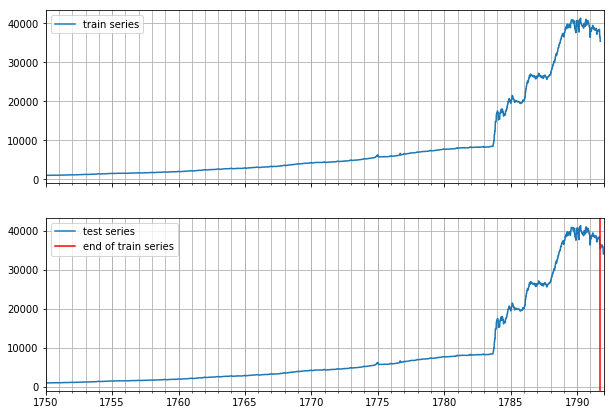

In [12]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [13]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [14]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df

## Results

## Study 1: `m4_quarterly_end2003q3`

In [16]:
dataname1

'm4_quarterly_end2003q3'

In [19]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data=dataname1, seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2003q3.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 66923


Seed: 42


100%|██████████| 200/200 [00:03<00:00, 62.78it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[0] Elapsed time 3.187 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.051452
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.22it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[1] Elapsed time 3.323 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.541894
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.41it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[2] Elapsed time 3.368 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.338102
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.81it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[3] Elapsed time 3.402 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.133379
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.64it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[4] Elapsed time 3.355 seconds
INFO:root:E

100%|██████████| 200/200 [00:03<00:00, 61.66it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[37] Elapsed time 3.245 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.363945
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 64.54it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[38] Elapsed time 3.100 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.350543
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.60it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[39] Elapsed time 3.357 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.346821
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.65it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[40] Elapsed time 3.194 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.374406
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.86it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[41] Elapsed time 3.235 second

100%|██████████| 200/200 [00:03<00:00, 62.81it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[74] Elapsed time 3.187 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.166178
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.91it/s, avg_epoch_loss=5.2]
INFO:root:Epoch[75] Elapsed time 3.285 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.198317
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.17it/s, avg_epoch_loss=5.23]
INFO:root:Epoch[76] Elapsed time 3.273 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.228318
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.99it/s, avg_epoch_loss=5.22]
INFO:root:Epoch[77] Elapsed time 3.281 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.215551
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.52it/s, avg_epoch_loss=5.2]
INFO:root:Epoch[78] Elapsed time 3.200 seconds


100%|██████████| 200/200 [00:03<00:00, 57.52it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[111] Elapsed time 3.478 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.154612
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.21it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[112] Elapsed time 3.269 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.124600
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.90it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[113] Elapsed time 3.340 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.124227
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.79it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[114] Elapsed time 3.403 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.122926
INFO:root:Epoch[115] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 64.46it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[115] Elapsed time

INFO:root:Epoch[148] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.84it/s, avg_epoch_loss=5.05]
INFO:root:Epoch[148] Elapsed time 3.185 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.053888
INFO:root:Loading parameters from best epoch (138)
INFO:root:Epoch[149] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 64.72it/s, avg_epoch_loss=5.02]
INFO:root:Epoch[149] Elapsed time 3.092 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.023513
INFO:root:Epoch[150] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 63.40it/s, avg_epoch_loss=5.01]
INFO:root:Epoch[150] Elapsed time 3.156 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.005666
INFO:root:Epoch[151] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 62.36it/s, avg_epoch_loss=5]
INFO:root:Epoch[151] Elapsed time 3.209 seconds
INFO:root:Epoch[151] Evaluation metric 'epoch_loss'=4.999822
INFO:root:Epoch[152] Learning rate is 0.0005
100%|███

INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=4.924135
INFO:root:Epoch[184] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 64.27it/s, avg_epoch_loss=4.92]
INFO:root:Epoch[184] Elapsed time 3.114 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=4.918042
INFO:root:Epoch[185] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 63.03it/s, avg_epoch_loss=4.93]
INFO:root:Epoch[185] Elapsed time 3.175 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=4.932656
INFO:root:Epoch[186] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 58.58it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[186] Elapsed time 3.415 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=4.901891
INFO:root:Epoch[187] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 59.87it/s, avg_epoch_loss=4.94]
INFO:root:Epoch[187] Elapsed time 3.342 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=4.936924
INFO:root:Epoch[188] Learning ra

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=4.896946
INFO:root:Epoch[220] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 55.54it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[220] Elapsed time 3.605 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=4.881688
INFO:root:Epoch[221] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 58.10it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[221] Elapsed time 3.444 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=4.890643
INFO:root:Epoch[222] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 61.15it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[222] Elapsed time 3.272 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=4.896604
INFO:root:Epoch[223] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 60.32it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[223] Elapsed time 3.317 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=4.886727
INFO:root:Loading parameters fro

100%|██████████| 200/200 [00:03<00:00, 58.26it/s, avg_epoch_loss=4.91]
INFO:root:Epoch[256] Elapsed time 3.434 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=4.912393
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.91it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[257] Elapsed time 3.457 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=4.885419
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.94it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[258] Elapsed time 3.339 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=4.893212
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.12it/s, avg_epoch_loss=4.91]
INFO:root:Epoch[259] Elapsed time 3.503 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=4.910001
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.92it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[260] Elapsed time

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.25it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[293] Elapsed time 3.267 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=4.859692
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.27it/s, avg_epoch_loss=4.85]
INFO:root:Epoch[294] Elapsed time 3.495 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=4.848221
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.82it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[295] Elapsed time 3.290 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=4.890549
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.17it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[296] Elapsed time 3.381 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=4.895689
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.29it/s, avg_epoch_l

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=4.852983
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.67it/s, avg_epoch_loss=4.83]
INFO:root:Epoch[330] Elapsed time 3.470 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=4.833650
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.94it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[331] Elapsed time 3.577 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=4.883330
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.69it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[332] Elapsed time 3.409 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=4.899399
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.53it/s, avg_epoch_loss=4.84]
INFO:root:Epoch[333] Elapsed time 3.478 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=4.844303
INFO:root:Epoch[334] Learning rate is 5e-05


100%|██████████| 200/200 [00:03<00:00, 56.45it/s, avg_epoch_loss=4.84]
INFO:root:Epoch[366] Elapsed time 3.545 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=4.843400
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.08it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[367] Elapsed time 3.506 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=4.856607
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.75it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[368] Elapsed time 3.589 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=4.885487
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.60it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[369] Elapsed time 3.304 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=4.862262
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.14it/s, avg_epoch_loss=4.83]
INFO:root:Epoch[370] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.117566  0.044179  19.652122            0.047073             0.03073   

   seed  epochs  num_batches  
0    42     400          200  
Seed: 43


100%|██████████| 200/200 [00:03<00:00, 60.35it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[0] Elapsed time 3.316 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.205902
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.70it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[1] Elapsed time 3.191 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.520697
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.79it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[2] Elapsed time 3.187 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.210834
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.07it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[3] Elapsed time 3.506 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.019107
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.96it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[4] Elapsed time 3.179 seconds
INFO:root:E

100%|██████████| 200/200 [00:03<00:00, 57.64it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[37] Elapsed time 3.471 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.334955
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.77it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[38] Elapsed time 3.464 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.309791
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.92it/s, avg_epoch_loss=5.3]
INFO:root:Epoch[39] Elapsed time 3.396 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.296146
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.68it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[40] Elapsed time 3.192 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.314814
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.77it/s, avg_epoch_loss=5.24]
INFO:root:Epoch[41] Elapsed time 3.188 seconds

100%|██████████| 200/200 [00:03<00:00, 54.53it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[74] Elapsed time 3.670 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.177487
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.12it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[75] Elapsed time 3.274 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.124063
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.55it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[76] Elapsed time 3.360 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.118939
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.48it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[77] Elapsed time 3.308 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.127147
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.11it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[78] Elapsed time 3.275 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 59.23it/s, avg_epoch_loss=5.04]
INFO:root:Epoch[111] Elapsed time 3.378 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.037339
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 59.16it/s, avg_epoch_loss=5.04]
INFO:root:Epoch[112] Elapsed time 3.382 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.041170
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 55.77it/s, avg_epoch_loss=5]
INFO:root:Epoch[113] Elapsed time 3.587 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=4.996440
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 55.73it/s, avg_epoch_loss=5.01]
INFO:root:Epoch[114] Elapsed time 3.590 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.013386
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 56.97it/s, avg_epoc

100%|██████████| 200/200 [00:03<00:00, 57.59it/s, avg_epoch_loss=4.92]
INFO:root:Epoch[147] Elapsed time 3.475 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=4.919670
INFO:root:Epoch[148] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 57.40it/s, avg_epoch_loss=4.94]
INFO:root:Epoch[148] Elapsed time 3.486 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=4.937328
INFO:root:Epoch[149] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 58.20it/s, avg_epoch_loss=4.96]
INFO:root:Epoch[149] Elapsed time 3.438 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=4.958489
INFO:root:Epoch[150] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 57.86it/s, avg_epoch_loss=4.98]
INFO:root:Epoch[150] Elapsed time 3.460 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=4.977116
INFO:root:Epoch[151] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 54.67it/s, avg_epoch_loss=4.91]
INFO:root:Epoch[151] Elap

INFO:root:Epoch[183] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 58.64it/s, avg_epoch_loss=4.92]
INFO:root:Epoch[183] Elapsed time 3.412 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=4.924722
INFO:root:Epoch[184] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 55.39it/s, avg_epoch_loss=4.93]
INFO:root:Epoch[184] Elapsed time 3.613 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=4.928071
INFO:root:Epoch[185] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 58.43it/s, avg_epoch_loss=4.92]
INFO:root:Epoch[185] Elapsed time 3.425 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=4.921794
INFO:root:Epoch[186] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 56.95it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[186] Elapsed time 3.515 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=4.896387
INFO:root:Epoch[187] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 58.50it

100%|██████████| 200/200 [00:03<00:00, 62.64it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[219] Elapsed time 3.194 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=4.903945
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.05it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[220] Elapsed time 3.333 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=4.897444
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.03it/s, avg_epoch_loss=4.92]
INFO:root:Epoch[221] Elapsed time 3.572 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=4.916244
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 62.19it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[222] Elapsed time 3.217 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=4.904376
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.37it/s, avg_epoch_loss=4.91]
INFO:root:Epoch[223] Elapsed time 3.

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.23it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[256] Elapsed time 3.379 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=4.902028
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.13it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[257] Elapsed time 3.384 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=4.864494
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.84it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[258] Elapsed time 3.520 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=4.880957
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.55it/s, avg_epoch_loss=4.87]
INFO:root:Epoch[259] Elapsed time 3.305 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=4.874949
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.72it/s, avg_epoch_l

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=4.846650
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.61it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[293] Elapsed time 3.248 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=4.880326
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.66it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[294] Elapsed time 3.531 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=4.875215
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.20it/s, avg_epoch_loss=4.91]
INFO:root:Epoch[295] Elapsed time 3.382 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=4.912029
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.40it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[296] Elapsed time 3.427 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=4.855434
INFO:root:Epoch[297] Learning rate is 5e-05

100%|██████████| 200/200 [00:03<00:00, 57.45it/s, avg_epoch_loss=4.84]
INFO:root:Epoch[329] Elapsed time 3.483 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=4.844679
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.23it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[330] Elapsed time 3.436 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=4.858818
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.12it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[331] Elapsed time 3.443 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=4.877863
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 62.10it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[332] Elapsed time 3.223 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=4.878466
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.21it/s, avg_epoch_loss=4.87]
INFO:root:Epoch[333] Elapsed time

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.99it/s, avg_epoch_loss=4.85]
INFO:root:Epoch[366] Elapsed time 3.450 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=4.853499
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.85it/s, avg_epoch_loss=4.83]
INFO:root:Epoch[367] Elapsed time 3.650 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=4.829782
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.47it/s, avg_epoch_loss=4.85]
INFO:root:Epoch[368] Elapsed time 3.309 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=4.850438
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 62.41it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[369] Elapsed time 3.206 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=4.880897
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.92it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.111578  0.044191  18.554143            0.046094             0.02821   

   seed  epochs  num_batches  
0    43     400          200  
Seed: 44


100%|██████████| 200/200 [00:03<00:00, 57.05it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[0] Elapsed time 3.508 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.026744
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.23it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[1] Elapsed time 3.378 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.500636
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.18it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[2] Elapsed time 3.325 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.268604
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.70it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[3] Elapsed time 3.243 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.143085
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.69it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[4] Elapsed time 3.529 seconds
INFO:root:Ep

100%|██████████| 200/200 [00:03<00:00, 63.02it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[37] Elapsed time 3.175 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.289473
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.99it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[38] Elapsed time 3.511 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.285008
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.96it/s, avg_epoch_loss=5.28]
INFO:root:Epoch[39] Elapsed time 3.452 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.282249
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.88it/s, avg_epoch_loss=5.25]
INFO:root:Epoch[40] Elapsed time 3.287 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.249951
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.61it/s, avg_epoch_loss=5.27]
INFO:root:Epoch[41] Elapsed time 3.248 second

100%|██████████| 200/200 [00:03<00:00, 59.47it/s, avg_epoch_loss=5.19]
INFO:root:Epoch[74] Elapsed time 3.364 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.193894
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.35it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[75] Elapsed time 3.315 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.141309
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 54.08it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[76] Elapsed time 3.700 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.137692
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.45it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[77] Elapsed time 3.423 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.148932
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.19it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[78] Elapsed time 3.561 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 57.40it/s, avg_epoch_loss=5.03]
INFO:root:Epoch[111] Elapsed time 3.486 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.030312
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 59.81it/s, avg_epoch_loss=5.04]
INFO:root:Epoch[112] Elapsed time 3.345 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.038596
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 62.25it/s, avg_epoch_loss=5.02]
INFO:root:Epoch[113] Elapsed time 3.215 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.023990
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 61.68it/s, avg_epoch_loss=5.02]
INFO:root:Epoch[114] Elapsed time 3.244 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.021178
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 61.26it/s, avg_e

INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=4.983621
INFO:root:Epoch[148] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 57.18it/s, avg_epoch_loss=4.97]
INFO:root:Epoch[148] Elapsed time 3.500 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=4.971371
INFO:root:Epoch[149] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 57.80it/s, avg_epoch_loss=4.99]
INFO:root:Epoch[149] Elapsed time 3.462 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=4.990222
INFO:root:Epoch[150] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 61.50it/s, avg_epoch_loss=5.01]
INFO:root:Epoch[150] Elapsed time 3.254 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.007311
INFO:root:Loading parameters from best epoch (140)
INFO:root:Epoch[151] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 58.90it/s, avg_epoch_loss=4.96]
INFO:root:Epoch[151] Elapsed time 3.397 seconds
INFO:root:Epoch[151] Evaluation metric 'epoch_lo

INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=4.919719
INFO:root:Epoch[184] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 57.61it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[184] Elapsed time 3.473 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=4.858273
INFO:root:Epoch[185] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 58.22it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[185] Elapsed time 3.437 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=4.902832
INFO:root:Epoch[186] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 62.92it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[186] Elapsed time 3.180 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=4.901091
INFO:root:Epoch[187] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 57.04it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[187] Elapsed time 3.509 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=4.875086
INFO:root:Epoch[188] Learning rat

100%|██████████| 200/200 [00:03<00:00, 59.11it/s, avg_epoch_loss=4.84]
INFO:root:Epoch[219] Elapsed time 3.385 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=4.844143
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.56it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[220] Elapsed time 3.477 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=4.897809
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.79it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[221] Elapsed time 3.239 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=4.899357
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.56it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[222] Elapsed time 3.538 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=4.860136
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.19it/s, avg_epoch_loss=4.91]
INFO:root:Epoch[223] Elapsed time 3

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.28it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[256] Elapsed time 3.268 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=4.860914
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.05it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[257] Elapsed time 3.278 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=4.886216
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.90it/s, avg_epoch_loss=4.84]
INFO:root:Epoch[258] Elapsed time 3.398 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=4.841301
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.99it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[259] Elapsed time 3.281 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=4.859868
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 62.38it/s, avg_epoch_

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=4.863794
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.07it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[293] Elapsed time 3.446 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=4.896772
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.49it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[294] Elapsed time 3.364 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=4.879619
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.02it/s, avg_epoch_loss=4.85]
INFO:root:Epoch[295] Elapsed time 3.390 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=4.845375
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.22it/s, avg_epoch_loss=4.84]
INFO:root:Epoch[296] Elapsed time 3.323 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=4.840076
INFO:root:Epoch[297] Learning rate is 5e-05


100%|██████████| 200/200 [00:03<00:00, 59.11it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[329] Elapsed time 3.385 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=4.889760
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.31it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[330] Elapsed time 3.553 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=4.856435
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.27it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[331] Elapsed time 3.376 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=4.889443
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.35it/s, avg_epoch_loss=4.84]
INFO:root:Epoch[332] Elapsed time 3.315 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=4.839461
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.26it/s, avg_epoch_loss=4.84]
INFO:root:Epoch[333] Elapsed time

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 62.05it/s, avg_epoch_loss=4.8]
INFO:root:Epoch[366] Elapsed time 3.224 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=4.803740
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.94it/s, avg_epoch_loss=4.83]
INFO:root:Epoch[367] Elapsed time 3.455 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=4.832128
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.80it/s, avg_epoch_loss=4.82]
INFO:root:Epoch[368] Elapsed time 3.463 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=4.818129
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.22it/s, avg_epoch_loss=4.87]
INFO:root:Epoch[369] Elapsed time 3.437 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=4.867698
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.94it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.073968  0.041942  17.990244            0.045449            0.028078   

   seed  epochs  num_batches  
0    44     400          200  
m4_weekly


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.117566,0.044179,19.652122,0.047073,0.030730,42,400,200
0,1.111578,0.044191,18.554143,0.046094,0.028210,43,400,200
0,1.073968,0.041942,17.990244,0.045449,0.028078,44,400,200


## Study 2: `m4_quarterly_end2013q1`

In [21]:
dataname2

'm4_quarterly_end2013q1'

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data=dataname2, seed=i, epochs=500, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2013q1.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 86473


Seed: 42


100%|██████████| 100/100 [00:01<00:00, 50.91it/s, avg_epoch_loss=7.77]
INFO:root:Epoch[0] Elapsed time 1.966 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.769876
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.93it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[1] Elapsed time 2.004 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.322463
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.29it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[2] Elapsed time 1.914 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.268443
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.87it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[3] Elapsed time 1.968 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.171642
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 51.22it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[4] Elapsed time 1.954 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 49.81it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[37] Elapsed time 2.009 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.795561
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.99it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[38] Elapsed time 2.002 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.795599
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.00it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[39] Elapsed time 2.042 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.809503
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.74it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[40] Elapsed time 2.012 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.755642
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.07it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[41] Elapsed time 2.040 seconds


100%|██████████| 100/100 [00:02<00:00, 49.86it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[74] Elapsed time 2.008 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.726763
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 50.28it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[75] Elapsed time 1.991 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.679832
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 50.48it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[76] Elapsed time 1.984 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.710797
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 50.81it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[77] Elapsed time 1.970 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.710400
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 48.42it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[78] Elapsed time 2.067 se

100%|██████████| 100/100 [00:01<00:00, 50.61it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[110] Elapsed time 1.978 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.660691
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 50.89it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[111] Elapsed time 1.967 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.676118
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 50.55it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[112] Elapsed time 1.980 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.658851
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 51.13it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[113] Elapsed time 1.960 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.691005
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 50.16it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[114] 

100%|██████████| 100/100 [00:01<00:00, 50.80it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[146] Elapsed time 1.970 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.661364
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.09it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[147] Elapsed time 1.998 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.674205
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.61it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[148] Elapsed time 2.017 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.656720
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.61it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[149] Elapsed time 1.939 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.657468
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.33it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.21it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[183] Elapsed time 2.034 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.658279
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.37it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[184] Elapsed time 2.027 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.670696
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.74it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[185] Elapsed time 2.013 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.696585
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.89it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[186] Elapsed time 2.006 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.650900
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.15it/s, avg_epoch_l

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.635968
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.98it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[220] Elapsed time 1.963 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.633313
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.25it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[221] Elapsed time 1.953 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.646395
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.33it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[222] Elapsed time 2.029 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.659532
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.23it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[223] Elapsed time 2.033 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.654885
INFO:root:Epoch[224] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 50.24it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[256] Elapsed time 1.992 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.635863
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.07it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[257] Elapsed time 2.040 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.624921
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.91it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[258] Elapsed time 1.966 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.640447
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.16it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[259] Elapsed time 2.122 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.661865
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.88it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[260] Elapsed time

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.67it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[293] Elapsed time 1.975 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.664072
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.63it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[294] Elapsed time 1.977 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.642576
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.33it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[295] Elapsed time 1.989 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.638008
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.31it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[296] Elapsed time 1.990 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.627230
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.15it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.672289
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.18it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[330] Elapsed time 1.995 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.618241
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.72it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[331] Elapsed time 2.013 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.635414
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.35it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[332] Elapsed time 2.029 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.631202
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.47it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[333] Elapsed time 2.023 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.623976
INFO:root:Epoch[334] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 50.39it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[366] Elapsed time 1.986 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.607714
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.83it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[367] Elapsed time 1.969 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.602013
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.09it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[368] Elapsed time 1.999 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.672725
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.57it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[369] Elapsed time 2.021 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.633937
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.95it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[370] Elapsed time 

INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.06it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[403] Elapsed time 1.960 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=6.639385
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.43it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[404] Elapsed time 1.985 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=6.614545
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.27it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[405] Elapsed time 1.952 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=6.617725
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.83it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[406] Elapsed time 1.972 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=6.596905
INFO:root:Epoch[407] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.27it/s, avg_epoch_l

INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=6.609280
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.23it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[440] Elapsed time 2.033 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.585319
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.35it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[441] Elapsed time 1.989 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=6.624352
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.75it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[442] Elapsed time 2.012 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=6.610928
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.05it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[443] Elapsed time 1.960 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=6.610921
INFO:root:Epoch[444] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 50.14it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[476] Elapsed time 1.996 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.605236
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.24it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[477] Elapsed time 2.033 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.627219
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.04it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[478] Elapsed time 2.041 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.606409
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.17it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[479] Elapsed time 1.995 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.593171
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.27it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[480] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.122995  0.088496  10.763847            0.082055             0.03916   

   seed  epochs  num_batches  
0    42     500          100  
Seed: 43


100%|██████████| 100/100 [00:02<00:00, 48.94it/s, avg_epoch_loss=7.91]
INFO:root:Epoch[0] Elapsed time 2.045 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.909329
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.30it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[1] Elapsed time 2.030 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.326727
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.76it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[2] Elapsed time 2.013 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.264451
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.84it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[3] Elapsed time 2.008 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.131503
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.51it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[4] Elapsed time 1.981 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 50.98it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[37] Elapsed time 1.964 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.774593
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 51.63it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[38] Elapsed time 1.939 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.744043
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.89it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[39] Elapsed time 1.967 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.761660
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 51.12it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[40] Elapsed time 1.958 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.785026
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.82it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[41] Elapsed time 2.009 second

100%|██████████| 100/100 [00:01<00:00, 51.14it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[74] Elapsed time 1.957 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.706178
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.72it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[75] Elapsed time 1.974 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.676578
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.07it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[76] Elapsed time 1.923 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.681262
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.96it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[77] Elapsed time 1.964 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.678550
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.05it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[78] Elapsed time 1.923 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 50.59it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[111] Elapsed time 1.979 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.601453
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 50.30it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[112] Elapsed time 1.990 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.603509
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 48.55it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[113] Elapsed time 2.061 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.635369
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 49.90it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[114] Elapsed time 2.008 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.609343
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 51.82it/s, avg_epo

100%|██████████| 100/100 [00:01<00:00, 50.72it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[147] Elapsed time 1.973 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.606362
INFO:root:Epoch[148] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 51.43it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[148] Elapsed time 1.948 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.632736
INFO:root:Epoch[149] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 50.41it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[149] Elapsed time 1.986 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.649767
INFO:root:Epoch[150] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 50.38it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[150] Elapsed time 1.987 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.584623
INFO:root:Epoch[151] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 51.28it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[151] Elap

INFO:root:Epoch[183] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 50.47it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[183] Elapsed time 1.983 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.609777
INFO:root:Epoch[184] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 49.78it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[184] Elapsed time 2.011 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.572606
INFO:root:Epoch[185] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 49.74it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[185] Elapsed time 2.012 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.597787
INFO:root:Epoch[186] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 51.63it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[186] Elapsed time 1.938 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.584256
INFO:root:Epoch[187] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 51.02it

100%|██████████| 100/100 [00:01<00:00, 50.37it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[219] Elapsed time 1.987 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.591360
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.50it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[220] Elapsed time 1.943 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.551451
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.08it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[221] Elapsed time 1.998 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.572213
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.79it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[222] Elapsed time 2.010 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.578150
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.46it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[223] Elapsed time

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.21it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[256] Elapsed time 1.957 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.556035
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.51it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[257] Elapsed time 1.943 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.559507
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.27it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[258] Elapsed time 1.955 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.593314
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.94it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[259] Elapsed time 1.968 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.573664
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.29it/s, avg_epoch_

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.558356
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.51it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[293] Elapsed time 1.982 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.576893
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.68it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[294] Elapsed time 1.975 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.595176
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.35it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[295] Elapsed time 2.029 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.589105
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.17it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[296] Elapsed time 1.918 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.579184
INFO:root:Epoch[297] Learning rate is 5e-05


100%|██████████| 100/100 [00:01<00:00, 52.35it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[329] Elapsed time 1.912 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.536990
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.94it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[330] Elapsed time 1.965 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.570039
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.30it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[331] Elapsed time 1.990 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.548219
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.73it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[332] Elapsed time 1.973 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.567836
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.68it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[333] Elapsed time

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.61it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[366] Elapsed time 1.941 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.559663
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.24it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[367] Elapsed time 1.956 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.558125
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.80it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[368] Elapsed time 2.010 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.554821
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.81it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[369] Elapsed time 2.009 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.590020
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.15it/s, avg_epoch_

INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=6.528486
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.57it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[403] Elapsed time 1.979 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=6.538161
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.75it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[404] Elapsed time 2.012 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=6.556226
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.31it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[405] Elapsed time 2.030 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=6.567122
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.89it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[406] Elapsed time 2.007 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=6.593325
INFO:root:Epoch[407] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 50.95it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[439] Elapsed time 1.965 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=6.566405
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.02it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[440] Elapsed time 2.001 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.571159
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.60it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[441] Elapsed time 1.978 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=6.594278
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.94it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[442] Elapsed time 1.965 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=6.550061
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.93it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[443] Elapsed time

INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.08it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[476] Elapsed time 2.082 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.558608
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.45it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[477] Elapsed time 1.984 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.554032
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.48it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[478] Elapsed time 1.983 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.577522
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.80it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[479] Elapsed time 2.010 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.537088
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.61it/s, avg_epoch_

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.114254  0.08739  10.192932            0.081091            0.039235    43   

   epochs  num_batches  
0     500          100  
Seed: 44


100%|██████████| 100/100 [00:02<00:00, 49.21it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[0] Elapsed time 2.034 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.695468
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.05it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[1] Elapsed time 2.000 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.360139
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.63it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[2] Elapsed time 1.977 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.260903
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.58it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[3] Elapsed time 2.020 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.140809
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.17it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[4] Elapsed time 2.035 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:02<00:00, 49.76it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[37] Elapsed time 2.011 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.750987
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.79it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[38] Elapsed time 1.971 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.757374
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.98it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[39] Elapsed time 1.963 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.773050
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.86it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[40] Elapsed time 2.008 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.779564
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.76it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[41] Elapsed time 2.012 second

100%|██████████| 100/100 [00:01<00:00, 50.40it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[74] Elapsed time 1.986 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.694016
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 50.58it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[75] Elapsed time 1.979 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.662060
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 51.13it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[76] Elapsed time 1.958 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.669330
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 51.71it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[77] Elapsed time 1.936 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.634592
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 51.56it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[78] Elapsed time 1.943 se

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.628114
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 49.98it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[111] Elapsed time 2.003 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.657728
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 52.03it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[112] Elapsed time 1.924 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.637917
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 51.13it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[113] Elapsed time 1.959 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.652663
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 51.30it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[114] Elapsed time 1.953 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.651989
INFO:root:Epoch[115] Learning rate 

100%|██████████| 100/100 [00:02<00:00, 49.55it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[146] Elapsed time 2.020 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.628209
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.80it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[147] Elapsed time 2.013 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.635382
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.03it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[148] Elapsed time 2.128 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.633185
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.45it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[149] Elapsed time 1.984 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.642600
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.78it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.11it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[183] Elapsed time 1.958 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.606302
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.17it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[184] Elapsed time 1.918 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.656210
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.22it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[185] Elapsed time 1.954 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.633557
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.41it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[186] Elapsed time 1.986 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.627484
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.68it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.654848
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.10it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[220] Elapsed time 1.961 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.635954
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.99it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[221] Elapsed time 1.963 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.650786
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.46it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[222] Elapsed time 1.946 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.610160
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.76it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[223] Elapsed time 1.974 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.621232
INFO:root:Epoch[224] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 51.72it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[256] Elapsed time 1.935 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.570600
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.23it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[257] Elapsed time 1.992 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.618662
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.53it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[258] Elapsed time 1.981 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.640123
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.91it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[259] Elapsed time 1.967 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.618151
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.46it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[260] Elapsed time

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.49it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[293] Elapsed time 1.944 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.611104
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.59it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[294] Elapsed time 1.978 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.605319
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.83it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[295] Elapsed time 1.969 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.601816
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.26it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[296] Elapsed time 1.992 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.588308
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.15it/s, avg_epoch_l

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.617059
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.14it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[330] Elapsed time 2.037 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.582416
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.94it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[331] Elapsed time 2.004 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.633222
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.87it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[332] Elapsed time 1.968 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.641819
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.21it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[333] Elapsed time 1.993 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.579809
INFO:root:Epoch[334] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 50.70it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[366] Elapsed time 1.974 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.601090
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.16it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[367] Elapsed time 1.995 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.607294
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.94it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[368] Elapsed time 2.005 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.632918
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.28it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[369] Elapsed time 2.037 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.617523
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.42it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[370] Elapsed time 

INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.76it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[403] Elapsed time 1.973 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=6.582044
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.71it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[404] Elapsed time 1.973 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=6.591921
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.60it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[405] Elapsed time 1.943 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=6.581608
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.44it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[406] Elapsed time 1.986 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=6.581441
INFO:root:Epoch[407] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.38it/s, avg_epoch_

INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=6.593118
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.97it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[440] Elapsed time 1.964 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.611732
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.23it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[441] Elapsed time 1.993 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=6.617094
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.11it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[442] Elapsed time 1.961 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=6.569840
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.33it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[443] Elapsed time 2.029 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=6.585428
INFO:root:Epoch[444] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 50.73it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[476] Elapsed time 1.973 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.598932
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.62it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[477] Elapsed time 1.977 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.563602
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.25it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[478] Elapsed time 1.953 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.594115
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.64it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[479] Elapsed time 1.939 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.608434
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.26it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[480] Elapsed time 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.188678  0.090396  11.567811            0.084239            0.039161   

   seed  epochs  num_batches  
0    44     500          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.122995,0.088496,10.763847,0.082055,0.039160,42,500,100
0,1.114254,0.087390,10.192932,0.081091,0.039235,43,500,100
0,1.188678,0.090396,11.567811,0.084239,0.039161,44,500,100


## Study 3: `m4_quarterly_end2015q1`

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname3, seed=i, epochs=100, batches=50)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2015q1.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 236823


Seed: 42


100%|██████████| 50/50 [00:01<00:00, 49.12it/s, avg_epoch_loss=8.22]
INFO:root:Epoch[0] Elapsed time 1.021 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.219393
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 47.55it/s, avg_epoch_loss=7.77]
INFO:root:Epoch[1] Elapsed time 1.053 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.773117
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.75it/s, avg_epoch_loss=7.51]
INFO:root:Epoch[2] Elapsed time 1.027 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.508757
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.18it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[3] Elapsed time 1.018 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.331586
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.65it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[4] Elapsed time 1.030 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.29it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[38] Elapsed time 1.018 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.858867
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.59it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[39] Elapsed time 1.031 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.621839
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.33it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[40] Elapsed time 1.036 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.786538
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.73it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[41] Elapsed time 1.007 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.742848
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 47.89it/s, avg_epoch_loss=6.89]
INFO:root:Ep

100%|██████████| 50/50 [00:01<00:00, 49.29it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[75] Elapsed time 1.016 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.464424
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 48.84it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[76] Elapsed time 1.025 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.690448
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 49.21it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[77] Elapsed time 1.019 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.626190
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 47.59it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[78] Elapsed time 1.052 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.685884
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 48.97it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[79] Elapsed time 1.023 seconds
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.222435  0.103419  13.271653            0.093777            0.052197   

   seed  epochs  num_batches  
0    42     100           50  
Seed: 43


100%|██████████| 50/50 [00:01<00:00, 49.69it/s, avg_epoch_loss=8.19]
INFO:root:Epoch[0] Elapsed time 1.008 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.192995
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 47.26it/s, avg_epoch_loss=7.77]
INFO:root:Epoch[1] Elapsed time 1.059 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.767062
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.93it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[2] Elapsed time 1.003 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.657734
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.37it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[3] Elapsed time 1.014 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.418952
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.17it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[4] Elapsed time 1.019 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.910938
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 48.66it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[38] Elapsed time 1.029 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.812784
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 48.88it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[39] Elapsed time 1.027 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.671207
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 49.05it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[40] Elapsed time 1.021 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.828490
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 51.51it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[41] Elapsed time 0.973 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.692236
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████|

100%|██████████| 50/50 [00:01<00:00, 49.88it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[74] Elapsed time 1.005 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.737593
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 49.58it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[75] Elapsed time 1.010 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.576829
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 48.82it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[76] Elapsed time 1.027 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.763609
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 51.15it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[77] Elapsed time 0.979 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.649515
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 49.57it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[78] Elapsed time 1.010 secon

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.548972  0.116469  19.741406            0.107813            0.063364   

   seed  epochs  num_batches  
0    43     100           50  
Seed: 44


100%|██████████| 50/50 [00:01<00:00, 49.37it/s, avg_epoch_loss=7.93]
INFO:root:Epoch[0] Elapsed time 1.015 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.928539
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 45.51it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[1] Elapsed time 1.100 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.704547
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.89it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[2] Elapsed time 1.024 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.620883
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.81it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[3] Elapsed time 0.882 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.312044
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.14it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[4] Elapsed time 0.892 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.97it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[38] Elapsed time 1.023 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.779436
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.97it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[39] Elapsed time 1.002 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.758216
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 50.00it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[40] Elapsed time 1.002 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.800659
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.79it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[41] Elapsed time 1.006 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.632456
INFO:root:Loading parameters from best epoch (31)
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<0

INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.773797
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 51.44it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[75] Elapsed time 0.975 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.581312
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 48.86it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[76] Elapsed time 1.026 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.861842
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 49.72it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[77] Elapsed time 1.008 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.731773
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 48.97it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[78] Elapsed time 1.023 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.826423
INFO:root:Epoch[79] Learning rate is 0.000125
100%|█

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.272797  0.103918  14.587026            0.095812             0.05524   

   seed  epochs  num_batches  
0    44     100           50  
Seed: 45


100%|██████████| 50/50 [00:01<00:00, 45.32it/s, avg_epoch_loss=8.16]
INFO:root:Epoch[0] Elapsed time 1.110 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.159892
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 47.48it/s, avg_epoch_loss=7.78]
INFO:root:Epoch[1] Elapsed time 1.055 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.782763
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.35it/s, avg_epoch_loss=7.56]
INFO:root:Epoch[2] Elapsed time 1.015 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.563544
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.62it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[3] Elapsed time 1.009 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.344748
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.32it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[4] Elapsed time 1.015 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:01<00:00, 48.24it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[37] Elapsed time 1.038 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.962885
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 49.75it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[38] Elapsed time 1.007 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.761739
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 49.93it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[39] Elapsed time 1.004 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.655856
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 40.75it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[40] Elapsed time 1.229 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.950079
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 49.81it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[41] Elapsed time 1.006 seconds
INFO

100%|██████████| 50/50 [00:01<00:00, 48.12it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[74] Elapsed time 1.041 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.700151
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 50.62it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[75] Elapsed time 0.990 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.554346
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 47.57it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[76] Elapsed time 1.053 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.850834
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 50.14it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[77] Elapsed time 0.999 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.693445
INFO:root:Loading parameters from best epoch (57)
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 50.02it/s, avg_epoch_loss=6.6

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.189693  0.100989  11.027135            0.091344            0.051971   

   seed  epochs  num_batches  
0    45     100           50  
Seed: 46


100%|██████████| 50/50 [00:01<00:00, 47.54it/s, avg_epoch_loss=8.01]
INFO:root:Epoch[0] Elapsed time 1.054 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.014542
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.91it/s, avg_epoch_loss=7.71]
INFO:root:Epoch[1] Elapsed time 1.067 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.709059
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.46it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[2] Elapsed time 1.015 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.543850
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.69it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[3] Elapsed time 1.008 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.359969
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.31it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[4] Elapsed time 1.016 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.944986
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 48.41it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[38] Elapsed time 1.034 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.864657
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 48.41it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[39] Elapsed time 1.034 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.632653
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 49.53it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[40] Elapsed time 1.011 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.914946
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 51.51it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[41] Elapsed time 0.972 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.672604
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████|

INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.678470
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 48.86it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[75] Elapsed time 1.025 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.614089
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 48.68it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[76] Elapsed time 1.029 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.716356
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 50.09it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[77] Elapsed time 1.000 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.636172
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 47.31it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[78] Elapsed time 1.058 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.822791
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.415074  0.108075  15.836062            0.101373            0.058788   

   seed  epochs  num_batches  
0    46     100           50  
Seed: 47


100%|██████████| 50/50 [00:01<00:00, 49.24it/s, avg_epoch_loss=8.2]
INFO:root:Epoch[0] Elapsed time 1.017 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.201225
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 47.51it/s, avg_epoch_loss=7.77]
INFO:root:Epoch[1] Elapsed time 1.054 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.768722
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.84it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[2] Elapsed time 1.026 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.618416
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.47it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[3] Elapsed time 1.013 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.430472
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.43it/s, avg_epoch_loss=7.51]
INFO:root:Epoch[4] Elapsed time 1.013 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.92it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[38] Elapsed time 1.024 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.788521
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.77it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[39] Elapsed time 1.027 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.783867
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.03it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[40] Elapsed time 1.023 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.748024
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.66it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[41] Elapsed time 1.008 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.644472
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 47.58it/s, avg_epoch_loss=6.88]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 50.70it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[75] Elapsed time 0.989 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.451932
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 49.30it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[76] Elapsed time 1.016 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.827907
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 49.56it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[77] Elapsed time 1.011 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.614531
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 49.90it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[78] Elapsed time 1.003 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.648163
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 50.86it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[79] Elapsed time 0.985 seconds
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.220332  0.101905  14.644093            0.092174            0.051687   

   seed  epochs  num_batches  
0    47     100           50  
Seed: 48


100%|██████████| 50/50 [00:01<00:00, 46.75it/s, avg_epoch_loss=8.42]
INFO:root:Epoch[0] Elapsed time 1.076 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.418613
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.45it/s, avg_epoch_loss=7.77]
INFO:root:Epoch[1] Elapsed time 1.033 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.769755
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 50.02it/s, avg_epoch_loss=7.64]
INFO:root:Epoch[2] Elapsed time 1.001 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.640182
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 50.02it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[3] Elapsed time 1.003 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.420875
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.48it/s, avg_epoch_loss=7.51]
INFO:root:Epoch[4] Elapsed time 1.012 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 50.05it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[38] Elapsed time 1.001 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.795499
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 50.11it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[39] Elapsed time 1.000 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.725853
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.93it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[40] Elapsed time 1.003 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.894108
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 50.28it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[41] Elapsed time 0.999 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.724529
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 47.79it/s, avg_epoch_loss=6.94]
INFO:root:Epo

INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 48.49it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[75] Elapsed time 1.032 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.656243
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 48.93it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[76] Elapsed time 1.023 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.751091
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 50.40it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[77] Elapsed time 0.994 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.573559
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 48.57it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[78] Elapsed time 1.031 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.821778
INFO:root:Epoch[79] Learning rate is 0.000125
100%|██████████| 50

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.294128  0.105241  13.033063            0.096603            0.054435   

   seed  epochs  num_batches  
0    48     100           50  
Seed: 49


100%|██████████| 50/50 [00:01<00:00, 47.67it/s, avg_epoch_loss=8.21]
INFO:root:Epoch[0] Elapsed time 1.051 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.208072
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 45.98it/s, avg_epoch_loss=7.74]
INFO:root:Epoch[1] Elapsed time 1.089 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.740794
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.01it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[2] Elapsed time 1.022 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.612703
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 47.09it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[3] Elapsed time 1.063 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.449288
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.09it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[4] Elapsed time 1.020 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.85it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[38] Elapsed time 1.005 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.785972
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 51.02it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[39] Elapsed time 0.982 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.564798
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.69it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[40] Elapsed time 1.029 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.856481
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 50.01it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[41] Elapsed time 1.002 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.671139
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.76it/s, avg_epoch_loss=6.78]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 50.72it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[75] Elapsed time 0.988 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.434093
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 47.46it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[76] Elapsed time 1.055 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.795418
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 48.96it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[77] Elapsed time 1.023 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.703926
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 48.94it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[78] Elapsed time 1.023 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.500289
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 48.26it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[79] Elapsed time 1.041 seconds
INFO:ro

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.27521  0.104721  12.054282            0.096467             0.05366    49   

   epochs  num_batches  
0     100           50  
Seed: 50


100%|██████████| 50/50 [00:01<00:00, 47.91it/s, avg_epoch_loss=7.93]
INFO:root:Epoch[0] Elapsed time 1.046 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.933368
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 47.31it/s, avg_epoch_loss=7.68]
INFO:root:Epoch[1] Elapsed time 1.059 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.683069
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.26it/s, avg_epoch_loss=7.56]
INFO:root:Epoch[2] Elapsed time 1.017 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.558065
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.73it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[3] Elapsed time 1.007 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.308610
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.82it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[4] Elapsed time 1.006 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.35it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[38] Elapsed time 1.018 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.831171
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.17it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[39] Elapsed time 1.018 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.752210
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.52it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[40] Elapsed time 1.032 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.813914
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 50.28it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[41] Elapsed time 0.999 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.661581
INFO:root:Loading parameters from best epoch (31)
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<

100%|██████████| 50/50 [00:01<00:00, 49.97it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[75] Elapsed time 1.003 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.530971
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 49.69it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[76] Elapsed time 1.011 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.771559
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 50.06it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[77] Elapsed time 1.001 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.584976
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 48.30it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[78] Elapsed time 1.038 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.779064
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 49.49it/s, avg_epoch_loss=6.66]

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.201629  0.101936  11.408754            0.092665            0.051484   

   seed  epochs  num_batches  
0    50     100           50  
Seed: 51


100%|██████████| 50/50 [00:01<00:00, 47.64it/s, avg_epoch_loss=8.21]
INFO:root:Epoch[0] Elapsed time 1.053 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.206570
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.18it/s, avg_epoch_loss=7.68]
INFO:root:Epoch[1] Elapsed time 1.084 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.681479
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 50.01it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[2] Elapsed time 1.002 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.517061
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 51.05it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[3] Elapsed time 0.981 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.285438
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 51.08it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[4] Elapsed time 0.981 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 50.13it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[38] Elapsed time 1.000 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.889517
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.60it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[39] Elapsed time 1.009 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.686605
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.90it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[40] Elapsed time 1.004 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.748809
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 51.30it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[41] Elapsed time 0.976 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.591147
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.77it/s, avg_epoch_loss=6.87]
INFO:root:Ep

100%|██████████| 50/50 [00:01<00:00, 49.91it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[75] Elapsed time 1.007 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.425487
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.92it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[76] Elapsed time 1.024 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.677986
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 51.48it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[77] Elapsed time 0.975 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.581114
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 49.94it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[78] Elapsed time 1.004 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.687131
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 51.13it/s, avg_epoch_loss=6.54]
INF

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.322848  0.10606  17.740012            0.096758            0.057319    51   

   epochs  num_batches  
0     100           50  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.222435,0.103419,13.271653,0.093777,0.052197,42,100,50
0,1.548972,0.116469,19.741406,0.107813,0.063364,43,100,50
0,1.272797,0.103918,14.587026,0.095812,0.055240,44,100,50
0,1.189693,0.100989,11.027135,0.091344,0.051971,45,100,50
0,1.415074,0.108075,15.836062,0.101373,0.058788,46,100,50
0,1.220332,0.101905,14.644093,0.092174,0.051687,47,100,50
0,1.294128,0.105241,13.033063,0.096603,0.054435,48,100,50
0,1.275210,0.104721,12.054282,0.096467,0.053660,49,100,50
0,1.201629,0.101936,11.408754,0.092665,0.051484,50,100,50
0,1.322848,0.106060,17.740012,0.096758,0.057319,51,100,50


In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname3, seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2015q1.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 236823


Seed: 42


100%|██████████| 100/100 [00:02<00:00, 46.63it/s, avg_epoch_loss=8]
INFO:root:Epoch[0] Elapsed time 2.150 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.996255
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.64it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[1] Elapsed time 2.016 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.420171
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.92it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[2] Elapsed time 2.046 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.326177
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 47.88it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[3] Elapsed time 2.091 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.280108
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.89it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[4] Elapsed time 2.049 seconds
INFO:root:Epoch

100%|██████████| 100/100 [00:02<00:00, 49.33it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[37] Elapsed time 2.029 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.605089
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.42it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[38] Elapsed time 1.985 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.665552
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.21it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[39] Elapsed time 2.076 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.617131
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.39it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[40] Elapsed time 2.027 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.630740
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.27it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[41] Elapsed time 2.075 second

100%|██████████| 100/100 [00:02<00:00, 49.40it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[74] Elapsed time 2.026 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.577869
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 49.75it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[75] Elapsed time 2.011 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.509236
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 48.79it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[76] Elapsed time 2.051 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.534432
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 48.77it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[77] Elapsed time 2.052 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.469296
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 48.63it/s, avg_epoc

100%|██████████| 100/100 [00:02<00:00, 49.65it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[110] Elapsed time 2.016 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.537261
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 49.13it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[111] Elapsed time 2.037 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.458232
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 48.58it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[112] Elapsed time 2.060 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.523640
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 49.55it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[113] Elapsed time 2.020 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.430829
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 49.05it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[114] 

100%|██████████| 100/100 [00:02<00:00, 49.55it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[146] Elapsed time 2.022 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.479845
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.02it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[147] Elapsed time 2.001 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.484832
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.63it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[148] Elapsed time 1.979 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.444134
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.97it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[149] Elapsed time 2.003 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.581187
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.67it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.73it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[183] Elapsed time 2.054 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.407243
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.13it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[184] Elapsed time 2.037 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.491592
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.17it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[185] Elapsed time 2.078 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.471290
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.06it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[186] Elapsed time 1.999 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.467165
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.02it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.165294  0.100589  10.724694            0.090363            0.049155   

   seed  epochs  num_batches  
0    42     200          100  
Seed: 43


100%|██████████| 100/100 [00:02<00:00, 47.94it/s, avg_epoch_loss=7.98]
INFO:root:Epoch[0] Elapsed time 2.089 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.980029
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.32it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[1] Elapsed time 1.989 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.538343
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.17it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[2] Elapsed time 2.035 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.428444
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.14it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[3] Elapsed time 2.038 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.369121
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.55it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[4] Elapsed time 2.020 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 48.98it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[37] Elapsed time 2.045 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.611990
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 48.55it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[38] Elapsed time 2.065 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.629258
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 48.76it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[39] Elapsed time 2.053 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.659767
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 49.94it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[40] Elapsed time 2.005 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.598323
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 48.46it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[41] Elapsed time 2.068 sec

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.441428
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 48.40it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[74] Elapsed time 2.068 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.668140
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 48.42it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[75] Elapsed time 2.067 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.498768
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 48.56it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[76] Elapsed time 2.061 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.531804
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 48.89it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[77] Elapsed time 2.047 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.536519
INFO:root:Epoch[78] Learning rate is 0.000125

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.16it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[110] Elapsed time 2.036 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.639295
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.05it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[111] Elapsed time 2.000 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.509345
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.40it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[112] Elapsed time 1.986 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.565023
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.86it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[113] Elapsed time 2.008 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.440512
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.53it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.588478
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.09it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[147] Elapsed time 2.038 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.499393
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.88it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[148] Elapsed time 2.006 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.547671
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.77it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[149] Elapsed time 2.011 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.432586
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.10it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[150] Elapsed time 2.039 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.542724
INFO:root:Epoch[151] Learning rate is 5e-05


100%|██████████| 100/100 [00:02<00:00, 49.40it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[183] Elapsed time 2.026 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.469880
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.84it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[184] Elapsed time 2.011 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.541606
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.24it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[185] Elapsed time 1.992 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.445404
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.68it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[186] Elapsed time 2.057 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.561188
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.99it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[187] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.145162  0.099849  10.431292            0.089555            0.049899   

   seed  epochs  num_batches  
0    43     200          100  
Seed: 44


100%|██████████| 100/100 [00:02<00:00, 48.94it/s, avg_epoch_loss=7.82]
INFO:root:Epoch[0] Elapsed time 2.045 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.816543
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.22it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[1] Elapsed time 2.034 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.466464
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.16it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[2] Elapsed time 1.996 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.377638
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.12it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[3] Elapsed time 2.037 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.294652
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.04it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[4] Elapsed time 2.041 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 49.93it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[37] Elapsed time 2.007 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.565103
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.73it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[38] Elapsed time 2.054 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.724353
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.71it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[39] Elapsed time 2.055 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.649751
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.61it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[40] Elapsed time 2.059 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.605928
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.85it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[41] Elapsed time 2.049 second

100%|██████████| 100/100 [00:02<00:00, 48.83it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[74] Elapsed time 2.050 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.508809
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.26it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[75] Elapsed time 2.032 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.459416
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.10it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[76] Elapsed time 2.038 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.530817
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.07it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[77] Elapsed time 2.039 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.395632
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.65it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[78] Elapsed time 2.016 seconds

100%|██████████| 100/100 [00:02<00:00, 49.17it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[111] Elapsed time 2.035 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.411477
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.91it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[112] Elapsed time 2.047 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.444325
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.47it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[113] Elapsed time 1.983 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.340628
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.35it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[114] Elapsed time 2.070 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.473611
INFO:root:Loading parameters from best epoch (104)
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 48.75it/s, av

100%|██████████| 100/100 [00:02<00:00, 48.45it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[147] Elapsed time 2.065 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.368964
INFO:root:Epoch[148] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 48.96it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[148] Elapsed time 2.044 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.309189
INFO:root:Epoch[149] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 49.66it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[149] Elapsed time 2.015 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.367221
INFO:root:Epoch[150] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 47.83it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[150] Elapsed time 2.093 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.378664
INFO:root:Epoch[151] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 49.11it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[151] Elap

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.58it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[183] Elapsed time 2.019 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.358380
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.91it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[184] Elapsed time 2.046 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.318879
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.47it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[185] Elapsed time 2.023 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.342911
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.47it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[186] Elapsed time 2.065 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.385124
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.92it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.162486  0.099227  11.169721            0.090578            0.049578   

   seed  epochs  num_batches  
0    44     200          100  
Seed: 45


100%|██████████| 100/100 [00:02<00:00, 47.19it/s, avg_epoch_loss=7.97]
INFO:root:Epoch[0] Elapsed time 2.124 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.971328
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.82it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[1] Elapsed time 2.050 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.454146
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.46it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[2] Elapsed time 2.024 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.314922
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.26it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[3] Elapsed time 2.073 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.297346
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.22it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[4] Elapsed time 1.993 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:02<00:00, 49.18it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[37] Elapsed time 2.035 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.555076
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.16it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[38] Elapsed time 2.036 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.685184
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.27it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[39] Elapsed time 2.031 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.590085
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.88it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[40] Elapsed time 2.047 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.608134
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.83it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[41] Elapsed time 1.970 second

100%|██████████| 100/100 [00:02<00:00, 49.42it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[74] Elapsed time 2.025 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.504086
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.75it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[75] Elapsed time 2.056 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.465040
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.33it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[76] Elapsed time 2.070 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.538658
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.51it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[77] Elapsed time 2.022 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.336685
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.07it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[78] Elapsed time 2.039 seconds

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.418048
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 49.65it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[111] Elapsed time 2.016 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.449961
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 49.78it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[112] Elapsed time 2.011 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.279556
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 49.15it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[113] Elapsed time 2.036 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.481047
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 50.05it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[114] Elapsed time 2.002 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.390798
INFO:root:Epoch[115] Learning rate 

100%|██████████| 100/100 [00:02<00:00, 49.84it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[146] Elapsed time 2.009 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.374584
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 49.63it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[147] Elapsed time 2.019 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.437951
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 50.42it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[148] Elapsed time 1.985 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.239629
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 49.04it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[149] Elapsed time 2.041 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.502124
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 48.60it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[150] E

100%|██████████| 100/100 [00:02<00:00, 48.89it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[182] Elapsed time 2.047 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.380662
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.28it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[183] Elapsed time 2.034 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.397065
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.67it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[184] Elapsed time 2.015 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.295467
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.22it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[185] Elapsed time 2.076 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.439658
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.31it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[186] Elapsed time 2.

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.145209  0.098591  11.155985            0.089078            0.049513   

   seed  epochs  num_batches  
0    45     200          100  
Seed: 46


100%|██████████| 100/100 [00:02<00:00, 48.86it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[0] Elapsed time 2.049 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.861800
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.71it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[1] Elapsed time 2.014 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.451910
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.99it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[2] Elapsed time 2.002 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.363764
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.84it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[3] Elapsed time 2.049 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.313898
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.29it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[4] Elapsed time 2.030 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 49.33it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[37] Elapsed time 2.029 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.587242
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.38it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[38] Elapsed time 1.987 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.606985
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.66it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[39] Elapsed time 2.057 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.711162
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.90it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[40] Elapsed time 2.047 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.629900
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.87it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[41] Elapsed time 2.048 second

100%|██████████| 100/100 [00:02<00:00, 49.67it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[74] Elapsed time 2.015 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.436541
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.11it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[75] Elapsed time 2.081 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.588017
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.02it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[76] Elapsed time 2.042 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.495512
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.05it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[77] Elapsed time 2.001 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.499171
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.96it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[78] Elapsed time 2.045 seconds


INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 48.97it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[111] Elapsed time 2.044 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.427639
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 49.14it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[112] Elapsed time 2.037 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.457976
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 48.50it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[113] Elapsed time 2.066 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.426468
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 50.09it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[114] Elapsed time 1.998 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.331341
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 49.37it/s, avg_e

100%|██████████| 100/100 [00:02<00:00, 48.90it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[147] Elapsed time 2.047 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.419231
INFO:root:Epoch[148] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 49.62it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[148] Elapsed time 2.018 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.346375
INFO:root:Epoch[149] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 49.22it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[149] Elapsed time 2.034 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.439881
INFO:root:Epoch[150] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 50.98it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[150] Elapsed time 1.963 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.283918
INFO:root:Epoch[151] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 47.97it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[151] Elap

INFO:root:Loading parameters from best epoch (172)
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.81it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[183] Elapsed time 2.051 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.376128
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.12it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[184] Elapsed time 2.037 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.347052
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.29it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[185] Elapsed time 1.990 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.298597
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.65it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[186] Elapsed time 1.976 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.372656
INFO:root:Epoch[187] Learning rate is 5e-05
100%|█████

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.118285  0.096455  10.550632             0.08736            0.048184   

   seed  epochs  num_batches  
0    46     200          100  
Seed: 47


100%|██████████| 100/100 [00:02<00:00, 45.60it/s, avg_epoch_loss=7.98]
INFO:root:Epoch[0] Elapsed time 2.195 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.984974
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.31it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[1] Elapsed time 2.036 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.524444
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.70it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[2] Elapsed time 1.974 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.425429
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.72it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[3] Elapsed time 1.973 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.331057
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.22it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[4] Elapsed time 2.033 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 49.79it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[37] Elapsed time 2.010 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.516755
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.26it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[38] Elapsed time 2.074 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.735268
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.50it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[39] Elapsed time 2.064 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.633489
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.44it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[40] Elapsed time 2.024 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.648892
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.63it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[41] Elapsed time 2.017 seconds

100%|██████████| 100/100 [00:01<00:00, 50.21it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[74] Elapsed time 1.996 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.636975
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 48.50it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[75] Elapsed time 2.065 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.465382
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 49.56it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[76] Elapsed time 2.020 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.496191
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 50.89it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[77] Elapsed time 1.967 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.397842
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 49.43it/s, avg_epoch_loss

100%|██████████| 100/100 [00:02<00:00, 49.51it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[110] Elapsed time 2.022 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.532403
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 49.82it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[111] Elapsed time 2.011 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.437848
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 50.49it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[112] Elapsed time 1.982 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.448862
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 50.58it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[113] Elapsed time 1.979 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.342432
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 50.56it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[114] 

100%|██████████| 100/100 [00:02<00:00, 49.23it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[146] Elapsed time 2.035 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.386490
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.36it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[147] Elapsed time 1.987 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.475530
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.66it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[148] Elapsed time 1.978 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.349214
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.42it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[149] Elapsed time 2.025 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.505747
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.44it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.63it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[183] Elapsed time 2.058 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.498027
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.50it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[184] Elapsed time 2.025 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.303552
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.24it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[185] Elapsed time 2.035 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.468320
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.20it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[186] Elapsed time 2.034 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.375897
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.81it/s, avg_epoch_lo

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.153437  0.099006  10.578439            0.089677            0.050449   

   seed  epochs  num_batches  
0    47     200          100  
Seed: 48


100%|██████████| 100/100 [00:02<00:00, 44.25it/s, avg_epoch_loss=8.09]
INFO:root:Epoch[0] Elapsed time 2.262 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.094184
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.59it/s, avg_epoch_loss=7.53]
INFO:root:Epoch[1] Elapsed time 2.060 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.530528
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.97it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[2] Elapsed time 2.044 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.456424
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.11it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[3] Elapsed time 2.038 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.339041
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.43it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[4] Elapsed time 2.025 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 49.30it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[37] Elapsed time 2.030 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.664219
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.36it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[38] Elapsed time 2.028 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.601903
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.24it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[39] Elapsed time 2.076 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.732929
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.04it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[40] Elapsed time 2.041 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.617381
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.61it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[41] Elapsed time 2.018 seconds

100%|██████████| 100/100 [00:02<00:00, 48.74it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[74] Elapsed time 2.053 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.595712
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 48.80it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[75] Elapsed time 2.052 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.501079
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 49.27it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[76] Elapsed time 2.035 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.510246
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 49.22it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[77] Elapsed time 2.034 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.457354
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 49.18it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[78] Elapsed time 2.035 seco

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.563191
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 49.31it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[111] Elapsed time 2.030 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.366037
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 50.26it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[112] Elapsed time 1.991 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.474323
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 51.08it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[113] Elapsed time 1.960 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.365998
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 49.39it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[114] Elapsed time 2.026 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.541279
INFO:root:Epoch[115] Learning rate 

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.364657
INFO:root:Loading parameters from best epoch (126)
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 48.68it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[147] Elapsed time 2.057 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.417643
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 49.82it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[148] Elapsed time 2.009 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.337934
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 48.86it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[149] Elapsed time 2.051 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.410260
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 48.57it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[150] Elapsed time 2.062 seconds
INFO:root:Epoch[150] Evaluation metric 'e

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.77it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[183] Elapsed time 2.011 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.396080
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.91it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[184] Elapsed time 1.967 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.379822
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.32it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[185] Elapsed time 2.032 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.469505
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.53it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[186] Elapsed time 2.021 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.345745
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.75it/s, avg_epoch_l

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.151558  0.09829  11.009294            0.088431            0.049543    48   

   epochs  num_batches  
0     200          100  
Seed: 49


100%|██████████| 100/100 [00:02<00:00, 45.86it/s, avg_epoch_loss=7.97]
INFO:root:Epoch[0] Elapsed time 2.183 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.974433
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.72it/s, avg_epoch_loss=7.53]
INFO:root:Epoch[1] Elapsed time 2.054 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.530995
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.30it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[2] Elapsed time 2.032 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.383695
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.08it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[3] Elapsed time 2.039 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.327297
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.67it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[4] Elapsed time 1.978 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 49.29it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[37] Elapsed time 2.031 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.519106
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.35it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[38] Elapsed time 2.028 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.729871
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.75it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[39] Elapsed time 2.053 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.563441
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.71it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[40] Elapsed time 2.054 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.616928
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.22it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[41] Elapsed time 2.036 second

100%|██████████| 100/100 [00:02<00:00, 48.12it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[74] Elapsed time 2.081 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.528530
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 48.88it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[75] Elapsed time 2.048 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.481255
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 49.25it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[76] Elapsed time 2.032 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.496114
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 50.73it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[77] Elapsed time 1.973 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.321370
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 50.17it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[78] Elapsed time 1.995 sec

100%|██████████| 100/100 [00:02<00:00, 49.82it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[110] Elapsed time 2.010 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.463467
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 48.92it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[111] Elapsed time 2.046 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.490258
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 49.38it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[112] Elapsed time 2.027 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.447636
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 49.27it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[113] Elapsed time 2.031 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.483069
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 48.59it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[114] E

100%|██████████| 100/100 [00:02<00:00, 49.74it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[146] Elapsed time 2.013 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.423322
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.71it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[147] Elapsed time 1.974 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.437815
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.58it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[148] Elapsed time 1.801 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.346033
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.40it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[149] Elapsed time 2.068 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.503267
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.68it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[150] Elapsed time 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.73it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[183] Elapsed time 1.764 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.483343
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 62.40it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[184] Elapsed time 1.604 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.319126
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.32it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[185] Elapsed time 1.633 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.518024
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.11it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[186] Elapsed time 1.850 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.429039
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.18it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.163445  0.098925  10.859264            0.090686            0.050902   

   seed  epochs  num_batches  
0    49     200          100  
Seed: 50


100%|██████████| 100/100 [00:01<00:00, 59.39it/s, avg_epoch_loss=7.81]
INFO:root:Epoch[0] Elapsed time 1.686 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.808219
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.75it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[1] Elapsed time 2.053 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.433338
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.01it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[2] Elapsed time 1.820 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.377618
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.11it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[3] Elapsed time 1.784 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.273552
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.05it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[4] Elapsed time 1.887 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 53.43it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[37] Elapsed time 1.875 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.592612
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.52it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[38] Elapsed time 1.803 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.627695
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.72it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[39] Elapsed time 1.676 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.666905
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.83it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[40] Elapsed time 1.701 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.646027
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.87it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[41] Elapsed time 1.893 second

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.478199
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 59.41it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[74] Elapsed time 1.685 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.646084
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 57.60it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[75] Elapsed time 1.738 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.515774
INFO:root:Loading parameters from best epoch (55)
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 52.33it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[76] Elapsed time 1.912 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.613872
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 60.88it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[77] Elapsed time 1.645 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.511

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.469895
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.53it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[110] Elapsed time 1.870 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.625806
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.39it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[111] Elapsed time 1.714 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.603151
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.35it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[112] Elapsed time 1.659 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.557295
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.49it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[113] Elapsed time 1.837 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.544704
INFO:root:Epoch[114] Learning rate is 5e-05


100%|██████████| 100/100 [00:01<00:00, 56.84it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[146] Elapsed time 1.761 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.600187
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.00it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[147] Elapsed time 1.788 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.481460
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.09it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[148] Elapsed time 1.784 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.558508
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.17it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[149] Elapsed time 1.814 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.443752
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.44it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[150] Elapsed time 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.75it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[183] Elapsed time 1.934 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.530432
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.18it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[184] Elapsed time 1.918 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.498689
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.78it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[185] Elapsed time 1.732 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.528626
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.33it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[186] Elapsed time 1.659 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.575699
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.85it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.194142  0.102652  11.096775            0.092841            0.050589   

   seed  epochs  num_batches  
0    50     200          100  
Seed: 51


100%|██████████| 100/100 [00:01<00:00, 54.03it/s, avg_epoch_loss=7.94]
INFO:root:Epoch[0] Elapsed time 1.853 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.944024
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.97it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[1] Elapsed time 1.757 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.401249
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.11it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[2] Elapsed time 1.752 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.330802
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.04it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[3] Elapsed time 1.786 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.205125
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.33it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[4] Elapsed time 1.777 seconds
INFO:root:Epo

100%|██████████| 100/100 [00:01<00:00, 58.70it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[37] Elapsed time 1.706 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.514946
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.97it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[38] Elapsed time 1.821 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.629550
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.92it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[39] Elapsed time 1.891 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.623360
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.94it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[40] Elapsed time 1.822 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.567386
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.27it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[41] Elapsed time 1.915 second

100%|██████████| 100/100 [00:02<00:00, 48.05it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[74] Elapsed time 2.083 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.517433
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 57.46it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[75] Elapsed time 1.742 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.461719
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 56.65it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[76] Elapsed time 1.767 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.449308
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 55.17it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[77] Elapsed time 1.814 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.416263
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 54.57it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[78] Elapsed time 1.834 se

100%|██████████| 100/100 [00:01<00:00, 60.77it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[110] Elapsed time 1.647 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.477943
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 58.75it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[111] Elapsed time 1.704 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.419515
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 59.09it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[112] Elapsed time 1.694 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.413830
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 56.60it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[113] Elapsed time 1.768 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.413490
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 56.84it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[114] 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.57it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[146] Elapsed time 1.801 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.508485
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.18it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[147] Elapsed time 1.636 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.354319
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.52it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[148] Elapsed time 1.627 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.422378
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.16it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[149] Elapsed time 1.848 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.291163
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.00it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.491148
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.28it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[183] Elapsed time 1.688 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.371822
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.96it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[184] Elapsed time 1.788 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.375201
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.46it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[185] Elapsed time 1.629 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.294836
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.29it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[186] Elapsed time 1.633 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.427387
INFO:root:Epoch[187] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.149587  0.099337  10.481676            0.089803            0.049033   

   seed  epochs  num_batches  
0    51     200          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.165294,0.100589,10.724694,0.090363,0.049155,42,200,100
0,1.145162,0.099849,10.431292,0.089555,0.049899,43,200,100
0,1.162486,0.099227,11.169721,0.090578,0.049578,44,200,100
0,1.145209,0.098591,11.155985,0.089078,0.049513,45,200,100
0,1.118285,0.096455,10.550632,0.087360,0.048184,46,200,100
0,1.153437,0.099006,10.578439,0.089677,0.050449,47,200,100
0,1.151558,0.098290,11.009294,0.088431,0.049543,48,200,100
0,1.163445,0.098925,10.859264,0.090686,0.050902,49,200,100
0,1.194142,0.102652,11.096775,0.092841,0.050589,50,200,100
0,1.149587,0.099337,10.481676,0.089803,0.049033,51,200,100


In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data=dataname3, seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2015q1.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 236823


Seed: 42


100%|██████████| 200/200 [00:03<00:00, 56.62it/s, avg_epoch_loss=7.71]
INFO:root:Epoch[0] Elapsed time 3.534 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.708213
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.36it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[1] Elapsed time 3.614 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.303143
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.69it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[2] Elapsed time 3.469 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.133021
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.09it/s, avg_epoch_loss=7]
INFO:root:Epoch[3] Elapsed time 3.632 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.998296
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 51.69it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[4] Elapsed time 3.871 seconds
INFO:root:Epoch

100%|██████████| 200/200 [00:03<00:00, 57.64it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[37] Elapsed time 3.472 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.516765
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.42it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[38] Elapsed time 3.425 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.474513
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 54.85it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[39] Elapsed time 3.648 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.527559
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 52.59it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[40] Elapsed time 3.804 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.494010
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.81it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[41] Elapsed time 3.402 second

100%|██████████| 200/200 [00:03<00:00, 57.83it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[74] Elapsed time 3.460 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.400583
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 52.03it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[75] Elapsed time 3.845 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.359823
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 54.71it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[76] Elapsed time 3.657 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.365441
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.78it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[77] Elapsed time 3.524 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.404923
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 54.07it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[78] Elapsed time 3.701 seconds


INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 58.55it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[111] Elapsed time 3.417 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.273363
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 54.01it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[112] Elapsed time 3.705 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.308750
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 54.62it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[113] Elapsed time 3.663 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.252031
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 60.20it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[114] Elapsed time 3.324 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.312713
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 60.30it/s, avg_e

100%|██████████| 200/200 [00:03<00:00, 55.36it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[147] Elapsed time 3.615 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.217417
INFO:root:Epoch[148] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 57.38it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[148] Elapsed time 3.487 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.282307
INFO:root:Epoch[149] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 59.76it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[149] Elapsed time 3.348 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.205807
INFO:root:Epoch[150] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 56.19it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[150] Elapsed time 3.561 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.290073
INFO:root:Loading parameters from best epoch (140)
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 56.87

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.78it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[183] Elapsed time 3.404 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.241029
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.56it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[184] Elapsed time 3.304 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.285386
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.98it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[185] Elapsed time 3.511 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.167993
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.88it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[186] Elapsed time 3.518 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.290611
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.69it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.238736
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.21it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[220] Elapsed time 3.559 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.209713
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.53it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[221] Elapsed time 3.738 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.218363
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.71it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[222] Elapsed time 3.725 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.260738
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.89it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[223] Elapsed time 3.518 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.189804
INFO:root:Epoch[224] Learning rate is 5e-05

100%|██████████| 200/200 [00:03<00:00, 55.76it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[256] Elapsed time 3.588 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.185229
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.68it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[257] Elapsed time 3.412 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.274102
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.99it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[258] Elapsed time 3.574 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.218559
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.20it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[259] Elapsed time 3.560 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.235125
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.59it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[260] Elapsed time

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.40it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[293] Elapsed time 3.370 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.263492
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 52.18it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[294] Elapsed time 3.835 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.198602
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.72it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[295] Elapsed time 3.295 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.245392
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.70it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[296] Elapsed time 3.468 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.227508
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.35it/s, avg_epoch_l

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.233541
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.98it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[330] Elapsed time 3.641 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.173957
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.93it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[331] Elapsed time 3.577 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.232156
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.74it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[332] Elapsed time 3.526 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.211302
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.71it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[333] Elapsed time 3.529 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.216183
INFO:root:Epoch[334] Learning rate is 5e-05

100%|██████████| 200/200 [00:03<00:00, 60.25it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[366] Elapsed time 3.321 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.198416
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.64it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[367] Elapsed time 3.662 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.228642
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.99it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[368] Elapsed time 3.392 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.164374
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.45it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[369] Elapsed time 3.366 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.233376
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.97it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[370] Elapsed time 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.117868  0.098103  10.815135            0.088753            0.048392   

   seed  epochs  num_batches  
0    42     400          200  
Seed: 43


100%|██████████| 200/200 [00:03<00:00, 54.72it/s, avg_epoch_loss=7.76]
INFO:root:Epoch[0] Elapsed time 3.657 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.759186
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 53.43it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[1] Elapsed time 3.745 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.398783
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.66it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[2] Elapsed time 3.411 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.143655
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.11it/s, avg_epoch_loss=7]
INFO:root:Epoch[3] Elapsed time 3.443 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.999456
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.04it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[4] Elapsed time 3.571 seconds
INFO:root:Epoch

100%|██████████| 200/200 [00:03<00:00, 60.51it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[37] Elapsed time 3.307 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.467740
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.05it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[38] Elapsed time 3.635 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.430062
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.05it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[39] Elapsed time 3.570 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.484872
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.33it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[40] Elapsed time 3.552 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.437612
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.92it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[41] Elapsed time 3.516 second

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 55.05it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[74] Elapsed time 3.634 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.338117
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 54.44it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[75] Elapsed time 3.675 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.392470
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 56.84it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[76] Elapsed time 3.520 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.356267
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 57.83it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[77] Elapsed time 3.460 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.352384
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████

INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 55.87it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[110] Elapsed time 3.582 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.352615
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 52.77it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[111] Elapsed time 3.792 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.319174
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 56.09it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[112] Elapsed time 3.567 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.305322
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 60.67it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[113] Elapsed time 3.298 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.361206
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 55.58i

100%|██████████| 200/200 [00:03<00:00, 55.27it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[146] Elapsed time 3.620 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.359545
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.64it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[147] Elapsed time 3.533 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.290148
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.78it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[148] Elapsed time 3.722 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.363080
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.66it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[149] Elapsed time 3.729 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.322749
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.85it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[150] Elapsed time 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.26it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[183] Elapsed time 3.377 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.287173
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.10it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[184] Elapsed time 3.504 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.367909
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.52it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[185] Elapsed time 3.604 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.280715
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.22it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[186] Elapsed time 3.379 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.331226
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.80it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.314454
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.10it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[220] Elapsed time 3.631 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.327908
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.84it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[221] Elapsed time 3.649 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.273679
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.24it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[222] Elapsed time 3.689 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.299369
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.68it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[223] Elapsed time 3.727 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.261242
INFO:root:Epoch[224] Learning rate is 5e-05


100%|██████████| 200/200 [00:03<00:00, 58.02it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[256] Elapsed time 3.449 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.254529
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.34it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[257] Elapsed time 3.682 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.363745
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.57it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[258] Elapsed time 3.600 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.292469
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.37it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[259] Elapsed time 3.614 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.313079
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.38it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[260] Elapsed time 

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.05it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[293] Elapsed time 3.571 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.306708
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.77it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[294] Elapsed time 3.655 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.263716
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.10it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[295] Elapsed time 3.444 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.323412
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.42it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[296] Elapsed time 3.312 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.225676
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 50.89it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.241134
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.13it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[330] Elapsed time 3.565 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.318136
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.11it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[331] Elapsed time 3.567 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.254375
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.84it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[332] Elapsed time 3.585 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.285308
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.28it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[333] Elapsed time 3.555 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.278852
INFO:root:Epoch[334] Learning rate is 5e-05

100%|██████████| 200/200 [00:03<00:00, 56.72it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[366] Elapsed time 3.528 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.249200
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.59it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[367] Elapsed time 3.249 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.273881
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.94it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[368] Elapsed time 3.338 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.290841
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.33it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[369] Elapsed time 3.373 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.271201
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.38it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[370] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.135927  0.098272  10.447384            0.088799            0.048743   

   seed  epochs  num_batches  
0    43     400          200  
Seed: 44


100%|██████████| 200/200 [00:03<00:00, 59.79it/s, avg_epoch_loss=7.64]
INFO:root:Epoch[0] Elapsed time 3.347 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.641503
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.51it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[1] Elapsed time 3.541 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.336145
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.12it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[2] Elapsed time 3.503 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.158963
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 51.83it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[3] Elapsed time 3.861 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.017582
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 54.04it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[4] Elapsed time 3.703 seconds
INFO:root:E

100%|██████████| 200/200 [00:03<00:00, 54.70it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[37] Elapsed time 3.658 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.484113
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.76it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[38] Elapsed time 3.464 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.463224
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.31it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[39] Elapsed time 3.432 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.510524
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.17it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[40] Elapsed time 3.627 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.435510
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.18it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[41] Elapsed time 3.439 second

100%|██████████| 200/200 [00:03<00:00, 55.41it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[74] Elapsed time 3.611 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.347486
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.49it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[75] Elapsed time 3.481 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.344682
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 54.43it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[76] Elapsed time 3.676 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.308462
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 53.02it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[77] Elapsed time 3.774 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.391342
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.17it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[78] Elapsed time 3.627 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 55.08it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[111] Elapsed time 3.632 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.301596
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 57.50it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[112] Elapsed time 3.480 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.298127
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 58.35it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[113] Elapsed time 3.429 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.301897
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 50.84it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[114] Elapsed time 3.936 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.267185
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 54.94it/s, avg_epoc

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 60.87it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[147] Elapsed time 3.287 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.204869
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 57.67it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[148] Elapsed time 3.469 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.305284
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 56.50it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[149] Elapsed time 3.542 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.261267
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 54.86it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[150] Elapsed time 3.647 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.289241
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 56.14it

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.231918
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.68it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[183] Elapsed time 3.298 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.276662
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.98it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[184] Elapsed time 3.281 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.233187
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.99it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[185] Elapsed time 3.337 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.228471
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.00it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[186] Elapsed time 3.391 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.244915
INFO:root:Epoch[187] Learning rate is 5e-05

100%|██████████| 200/200 [00:03<00:00, 58.92it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[219] Elapsed time 3.396 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.254554
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.10it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[220] Elapsed time 3.275 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.228638
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.92it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[221] Elapsed time 3.455 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.302381
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.77it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[222] Elapsed time 3.465 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.231504
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.88it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[223] Elapsed time 

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.62it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[256] Elapsed time 3.473 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.218659
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.10it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[257] Elapsed time 3.386 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.301563
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.64it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[258] Elapsed time 3.662 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.205375
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.57it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[259] Elapsed time 3.666 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.248923
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.12it/s, avg_epoch_l

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.208991
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.82it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[293] Elapsed time 3.584 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.211772
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.37it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[294] Elapsed time 3.314 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.209808
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.26it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[295] Elapsed time 3.688 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.228064
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.60it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[296] Elapsed time 3.302 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.223191
INFO:root:Epoch[297] Learning rate is 5e-05

100%|██████████| 200/200 [00:03<00:00, 54.12it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[329] Elapsed time 3.697 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.169708
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.51it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[330] Elapsed time 3.671 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.252251
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.53it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[331] Elapsed time 3.419 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.206092
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.80it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[332] Elapsed time 3.652 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.263931
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.61it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[333] Elapsed time

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.06it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[366] Elapsed time 3.388 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.224514
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.59it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[367] Elapsed time 3.666 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.228227
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.72it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[368] Elapsed time 3.350 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.227843
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.03it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[369] Elapsed time 3.278 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.181937
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.30it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.138373  0.098803  11.217749             0.09033            0.049467   

   seed  epochs  num_batches  
0    44     400          200  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.117868,0.098103,10.815135,0.088753,0.048392,42,400,200
0,1.135927,0.098272,10.447384,0.088799,0.048743,43,400,200
0,1.138373,0.098803,11.217749,0.090330,0.049467,44,400,200


In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data=dataname3, seed=i, epochs=500, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2015q1.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 236823


Seed: 42


100%|██████████| 100/100 [00:01<00:00, 54.14it/s, avg_epoch_loss=8]
INFO:root:Epoch[0] Elapsed time 1.849 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.996255
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.53it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[1] Elapsed time 1.802 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.420171
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.49it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[2] Elapsed time 1.741 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.326177
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.19it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[3] Elapsed time 1.720 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.280108
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.26it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[4] Elapsed time 1.845 seconds
INFO:root:Epoch

100%|██████████| 100/100 [00:01<00:00, 59.75it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[37] Elapsed time 1.675 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.605089
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.61it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[38] Elapsed time 1.679 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.665552
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.46it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[39] Elapsed time 1.838 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.617131
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.54it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[40] Elapsed time 1.905 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.630740
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.92it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[41] Elapsed time 1.857 second

100%|██████████| 100/100 [00:01<00:00, 56.82it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[74] Elapsed time 1.762 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.577869
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 58.46it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[75] Elapsed time 1.712 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.509236
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 52.81it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[76] Elapsed time 1.895 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.534432
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 55.94it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[77] Elapsed time 1.789 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.469296
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 57.73it/s, avg_epoc

100%|██████████| 100/100 [00:01<00:00, 55.07it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[110] Elapsed time 1.817 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.537261
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 59.39it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[111] Elapsed time 1.685 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.458232
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 55.96it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[112] Elapsed time 1.788 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.523640
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 50.52it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[113] Elapsed time 1.981 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.430829
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 56.93it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[114] 

100%|██████████| 100/100 [00:01<00:00, 54.85it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[146] Elapsed time 1.825 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.479845
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.77it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[147] Elapsed time 1.827 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.484832
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.70it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[148] Elapsed time 1.649 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.444134
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.30it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[149] Elapsed time 1.660 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.581187
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.80it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.23it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[183] Elapsed time 1.690 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.407243
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.71it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[184] Elapsed time 1.649 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.491592
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.82it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[185] Elapsed time 1.701 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.471290
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.79it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[186] Elapsed time 1.794 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.467165
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.23it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.411717
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.28it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[220] Elapsed time 1.748 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.581455
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.24it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[221] Elapsed time 1.662 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.399817
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.08it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[222] Elapsed time 1.784 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.467618
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.27it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[223] Elapsed time 1.781 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.404878
INFO:root:Epoch[224] Learning rate is 5e-05
1

100%|██████████| 100/100 [00:01<00:00, 56.64it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[256] Elapsed time 1.767 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.447840
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.55it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[257] Elapsed time 1.905 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.410809
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.36it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[258] Elapsed time 1.715 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.524840
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.18it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[259] Elapsed time 1.636 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.352009
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.61it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[260] Elapsed time

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.95it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[293] Elapsed time 1.642 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.470818
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.82it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[294] Elapsed time 1.673 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.522753
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.86it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[295] Elapsed time 1.730 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.300138
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.36it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[296] Elapsed time 1.658 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.546331
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.78it/s, avg_epoch_l

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.383566
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.99it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[330] Elapsed time 2.043 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.485363
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.59it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[331] Elapsed time 1.978 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.345142
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.02it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[332] Elapsed time 1.696 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.491193
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.21it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[333] Elapsed time 1.994 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.415972
INFO:root:Epoch[334] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 59.42it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[366] Elapsed time 1.685 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.481562
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.28it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[367] Elapsed time 1.688 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.374658
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.91it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[368] Elapsed time 1.928 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.505682
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.64it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[369] Elapsed time 1.938 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.433556
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.02it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[370] Elapsed time 

INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.73it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[403] Elapsed time 1.863 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=6.391259
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.56it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[404] Elapsed time 1.801 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=6.414516
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.95it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[405] Elapsed time 1.760 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=6.385746
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.25it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[406] Elapsed time 1.846 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=6.449986
INFO:root:Epoch[407] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.41it/s, avg_epoch_

INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=6.513954
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.71it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[440] Elapsed time 1.797 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.354851
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.54it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[441] Elapsed time 1.770 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=6.426629
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.67it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[442] Elapsed time 1.768 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=6.292947
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.69it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[443] Elapsed time 1.677 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=6.497969
INFO:root:Epoch[444] Learning rate is 5e-05


100%|██████████| 100/100 [00:01<00:00, 59.61it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[476] Elapsed time 1.679 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.428910
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.25it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[477] Elapsed time 1.749 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.381765
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.69it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[478] Elapsed time 1.677 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.398215
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.87it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[479] Elapsed time 1.672 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.441773
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.65it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[480] Elapsed time 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.151123  0.099535  10.718942            0.090083            0.048407   

   seed  epochs  num_batches  
0    42     500          100  
Seed: 43


100%|██████████| 100/100 [00:01<00:00, 53.72it/s, avg_epoch_loss=7.98]
INFO:root:Epoch[0] Elapsed time 1.863 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.980029
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.15it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[1] Elapsed time 1.848 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.538343
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.73it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[2] Elapsed time 1.829 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.428444
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.40it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[3] Elapsed time 1.874 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.369121
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.76it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[4] Elapsed time 1.795 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 60.19it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[37] Elapsed time 1.663 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.611990
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 60.58it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[38] Elapsed time 1.652 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.629258
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 59.00it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[39] Elapsed time 1.697 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.659767
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 56.56it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[40] Elapsed time 1.769 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.598323
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 55.97it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[41] Elapsed time 1.788 sec

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.441428
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 53.07it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[74] Elapsed time 1.886 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.668140
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 55.42it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[75] Elapsed time 1.806 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.498768
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 53.53it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[76] Elapsed time 1.870 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.531804
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 49.43it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[77] Elapsed time 2.025 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.536519
INFO:root:Epoch[78] Learning rate is 0.000125

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.57it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[110] Elapsed time 1.680 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.639295
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.16it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[111] Elapsed time 1.692 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.509345
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.62it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[112] Elapsed time 1.868 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.565023
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.65it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[113] Elapsed time 1.768 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.440512
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.01it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.588478
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.55it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[147] Elapsed time 1.835 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.499393
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.88it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[148] Elapsed time 1.761 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.547671
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.72it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[149] Elapsed time 1.765 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.432586
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.70it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[150] Elapsed time 1.798 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.542724
INFO:root:Epoch[151] Learning rate is 5e-05


100%|██████████| 100/100 [00:01<00:00, 56.55it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[183] Elapsed time 1.770 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.469880
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.56it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[184] Elapsed time 1.770 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.541606
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.18it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[185] Elapsed time 1.663 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.445404
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.33it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[186] Elapsed time 1.659 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.561188
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.39it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[187] Elapsed time

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.81it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[220] Elapsed time 1.674 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.388398
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.42it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[221] Elapsed time 1.657 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.625122
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.07it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[222] Elapsed time 1.694 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.415897
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.21it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[223] Elapsed time 1.720 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.526358
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.14it/s, avg_epoch_

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.490613
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.02it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[257] Elapsed time 1.819 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.502993
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.92it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[258] Elapsed time 1.891 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.388148
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.10it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[259] Elapsed time 1.753 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.527176
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.99it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[260] Elapsed time 1.669 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.380249
INFO:root:Epoch[261] Learning rate is 5e-05


100%|██████████| 100/100 [00:01<00:00, 51.11it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[293] Elapsed time 1.958 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.409763
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.54it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[294] Elapsed time 1.770 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.448675
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.15it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[295] Elapsed time 1.883 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.417174
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.83it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[296] Elapsed time 2.050 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.476416
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.26it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[297] Elapsed time

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.08it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[330] Elapsed time 1.694 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.448249
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.40it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[331] Elapsed time 1.685 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.356633
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.66it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[332] Elapsed time 1.706 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.507924
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.29it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[333] Elapsed time 1.778 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.472372
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.97it/s, avg_epoch_

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.456101
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.81it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[367] Elapsed time 1.620 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.375943
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.61it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[368] Elapsed time 1.651 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.564730
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.82it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[369] Elapsed time 1.646 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.430743
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.41it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[370] Elapsed time 1.774 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.463948
INFO:root:Epoch[371] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 59.59it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[403] Elapsed time 1.680 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=6.391327
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.82it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[404] Elapsed time 1.702 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=6.500830
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.30it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[405] Elapsed time 1.688 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=6.374963
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.18it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[406] Elapsed time 1.814 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=6.475709
INFO:root:Epoch[407] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.42it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[407] Elapsed time 

INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.84it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[440] Elapsed time 1.645 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.384220
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.18it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[441] Elapsed time 1.720 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=6.516588
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.34it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[442] Elapsed time 1.687 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=6.266869
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.26it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[443] Elapsed time 1.811 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=6.524727
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.05it/s, avg_epoch_

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.411957
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.07it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[477] Elapsed time 1.724 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.363534
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.66it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[478] Elapsed time 1.706 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.431412
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.33it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[479] Elapsed time 1.913 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.484786
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.01it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[480] Elapsed time 1.696 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=6.338131
INFO:root:Epoch[481] Learning rate is 5e-05

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.121016  0.097162  10.20187            0.087628            0.049008    43   

   epochs  num_batches  
0     500          100  
Seed: 44


100%|██████████| 100/100 [00:01<00:00, 51.81it/s, avg_epoch_loss=7.82]
INFO:root:Epoch[0] Elapsed time 1.932 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.816543
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.99it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[1] Elapsed time 1.854 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.466464
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.19it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[2] Elapsed time 1.750 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.377638
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.23it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[3] Elapsed time 1.780 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.294652
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.84it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[4] Elapsed time 1.701 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 61.15it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[37] Elapsed time 1.637 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.565103
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.41it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[38] Elapsed time 1.685 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.724353
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.55it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[39] Elapsed time 1.653 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.649751
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.25it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[40] Elapsed time 1.689 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.605928
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.82it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[41] Elapsed time 1.646 second

100%|██████████| 100/100 [00:01<00:00, 55.83it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[74] Elapsed time 1.793 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.508809
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.62it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[75] Elapsed time 1.768 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.459416
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.32it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[76] Elapsed time 1.877 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.530817
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.71it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[77] Elapsed time 1.649 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.395632
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.06it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[78] Elapsed time 1.754 seconds

100%|██████████| 100/100 [00:01<00:00, 54.71it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[111] Elapsed time 1.829 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.411477
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.04it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[112] Elapsed time 1.755 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.444325
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.54it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[113] Elapsed time 1.681 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.340628
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.33it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[114] Elapsed time 1.659 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.473611
INFO:root:Loading parameters from best epoch (104)
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 59.78it/s, av

100%|██████████| 100/100 [00:01<00:00, 57.40it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[147] Elapsed time 1.746 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.368964
INFO:root:Epoch[148] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 61.15it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[148] Elapsed time 1.637 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.309189
INFO:root:Epoch[149] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 61.54it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[149] Elapsed time 1.627 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.367221
INFO:root:Epoch[150] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 52.34it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[150] Elapsed time 1.912 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.378664
INFO:root:Epoch[151] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 54.86it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[151] Elap

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.97it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[183] Elapsed time 1.757 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.358380
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.96it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[184] Elapsed time 1.727 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.318879
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.76it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[185] Elapsed time 1.763 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.342911
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.42it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[186] Elapsed time 1.806 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.385124
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.27it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.298019
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.65it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[220] Elapsed time 1.832 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.316491
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.80it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[221] Elapsed time 1.674 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.415242
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.37it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[222] Elapsed time 1.745 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.293254
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.35it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[223] Elapsed time 1.716 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.387813
INFO:root:Epoch[224] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 59.93it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[256] Elapsed time 1.670 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.398407
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.73it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[257] Elapsed time 1.734 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.377702
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.73it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[258] Elapsed time 1.648 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.312960
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.13it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[259] Elapsed time 1.638 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.314518
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.69it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[260] Elapsed time 

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.22it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[293] Elapsed time 1.749 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.258422
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.54it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[294] Elapsed time 1.802 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.358666
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.28it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[295] Elapsed time 1.747 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.166850
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.45it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[296] Elapsed time 1.773 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.437807
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.87it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.306906
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.16it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[330] Elapsed time 1.782 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.237728
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.37it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[331] Elapsed time 1.841 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.352182
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.59it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[332] Elapsed time 1.800 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.359250
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.09it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[333] Elapsed time 1.784 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.302165
INFO:root:Epoch[334] Learning rate is 5e-05


100%|██████████| 100/100 [00:01<00:00, 55.91it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[366] Elapsed time 1.790 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.242594
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.79it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[367] Elapsed time 1.647 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.421671
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.80it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[368] Elapsed time 1.860 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.258610
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.95it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[369] Elapsed time 1.758 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.319329
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.81it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[370] Elapsed time

INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.14it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[403] Elapsed time 1.883 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=6.256865
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.39it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[404] Elapsed time 1.840 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=6.308389
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.82it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[405] Elapsed time 1.931 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=6.246359
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.89it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[406] Elapsed time 1.929 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=6.340251
INFO:root:Epoch[407] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.84it/s, avg_epoch_

INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=6.247409
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.19it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[440] Elapsed time 1.663 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.320013
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.93it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[441] Elapsed time 1.728 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=6.248736
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.57it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[442] Elapsed time 2.019 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=6.380975
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.92it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[443] Elapsed time 2.006 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=6.337931
INFO:root:Epoch[444] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 55.47it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[476] Elapsed time 1.805 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.354738
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.93it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[477] Elapsed time 1.789 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.147985
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.32it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[478] Elapsed time 1.659 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.472004
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.41it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[479] Elapsed time 1.806 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.292877
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.11it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[480] Elapsed time 

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.128107  0.097648  10.66564            0.089184            0.048804    44   

   epochs  num_batches  
0     500          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.151123,0.099535,10.718942,0.090083,0.048407,42,500,100
0,1.121016,0.097162,10.201870,0.087628,0.049008,43,500,100
0,1.128107,0.097648,10.665640,0.089184,0.048804,44,500,100
